# Tutorial on using DMI data

This Python notebook presents a convenient function for retrieving meteorological observation data from the Danish Meteorological Institute (DMI). DMI offers observational data from both Denmark and Greenland.

You can read more about DMI's free data API [here](https://opendatadocs.dmi.govcloud.dk/en/Data/Meteorological_Observation_Data) or in this [blog post](https://predictablysunny.com/posts/dmi_data/).


## Step 0: Familiarize yourself with Google Colab

The notebook can be seamlessly run in Google Colab, a free no-installation tool for running Python code from your web browser. 

Notebooks are organized by text and code "cells".  You can double-click a cell to start editing it.  To render a text cell, or execute a code cell, hit shift+enter.

In the code cell below, try out some math calculations to explore how the notebook and Python works:

In [1]:
# Try and write some code here
a = 1
b = 2
print(a + b)

3


## Step 1: Import packages

The first step in almost all Python scripts is to load some packages also known as libraries:

In [2]:
import pandas as pd  # package for data analysis
import numpy as np  # package for math operations
import matplotlib.pyplot as plt  # package for plotting
import requests  # package for making web requests

## Step 2: Define a function to retrieve data

For convenience, this function has already been created, which takes care of the data request formatting. Skip to the next cell to retrieve the data:

In [3]:
def get_dmi(station, start, end, parameters, api_key):
    DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'
    
    # Derive datetime specifier string
    datetime_str = (
        pd.Timestamp(start).tz_localize('UTC').isoformat()
        + '/'
        + pd.Timestamp(end).tz_localize('UTC').isoformat()
    )
    
    dfs = []
    for parameter in parameters:
        params = {
            'api-key': api_key,
            'datetime': datetime_str,
            'stationId': station,
            'parameterId': parameter,
            'limit': '300000',
        }
    
        ii = 0
        dfis = []
        while True:
            if ii == 0:
                ii += 1
                r = requests.get(DMI_URL, params=params)
            else:
                ii += 1
                link = r.json().get('links', [])
                if link and link[-1]['title'] == 'Next set of results':
                    url = link[-1]['href']
                    r = requests.get(url)
                else:
                    break
    
            json = r.json()
            dfi = pd.json_normalize(json.get('features', []))
            if dfi.empty:
                continue
            dfi['time'] = pd.to_datetime(dfi['properties.observed'])
            dfi = dfi[['time', 'properties.value', 'properties.stationId', 'properties.parameterId']]
            dfi.columns = [c.replace('properties.', '') for c in dfi.columns]
            dfi = dfi[~dfi.duplicated()]
            dfi = dfi.set_index(['parameterId', 'time'])
            dfi = dfi['value'].unstack(['parameterId'])
            dfis.append(dfi)
    
        if not dfis:
            print(f"Station has no data: {station} for parameter: {parameter}")
            continue
    
        dfs.append(pd.concat(dfis, axis='rows').sort_index())
    
    if not dfs:
        print(f"No data collected for station {station}. Skipping...")
    
    df = pd.concat(dfs, axis='columns')
    return df

## Step 3: Specify your data requirements and retrieve data

Modify the parameters below to retrieve air temperature, wind speed, and wind direction from DMI's station in Sisimiut.

You can find a list of meteorological parameters [**here**](https://opendatadocs.dmi.govcloud.dk/en/Data/Meteorological_Observation_Data) and a list of available stations [**here**](https://opendatadocs.dmi.govcloud.dk/Data/Meteorological_Observation_Data_Stations).

In [4]:
# Specify all the Greenlandic active stations
station = '04202'

# Define period of interest
start = '2025-04-22'
end = '2025-04-23'

# Paste in your API key
api_key = ''

# Specify global radiation
parameters = ['temp_dry', 'wind_speed']

# Retrieve data
data = get_dmi(station, start, end, parameters, api_key)

## Step 4: Inspect the data

The retrieved data is in a Pandas DataFrame (``data``):

In [5]:
data.head()  # print the first five rows

parameterId,temp_dry,wind_speed,wind_dir
time,,,
2025-04-22 00:00:00+00:00,-4.2,2.6,290.0
2025-04-22 01:00:00+00:00,-4.4,2.6,290.0
2025-04-22 02:00:00+00:00,-4.7,2.6,280.0


## Step 5: Plot the data:

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

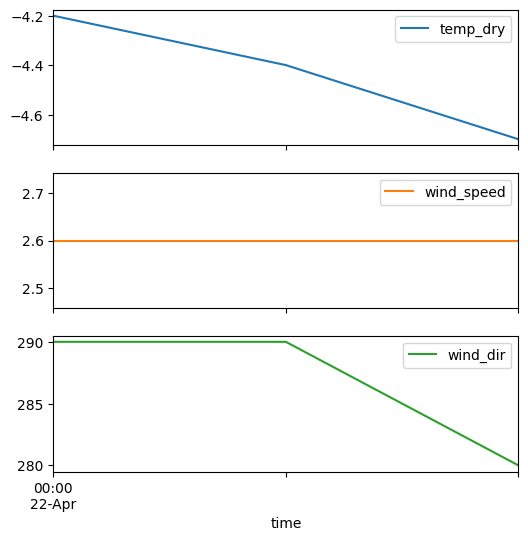

In [6]:
data.plot(figsize=(6, 6), sharex=True, subplots=True)